In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from data.loader import load_segmentation
from utils.session_config import setup_gpus
setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
train_ids = np.load("annotations/train_ids.npy")
test_ids = np.load("annotations/val_ids.npy")
coco = COCO("annotations/integrated_annotation.json")

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!


In [4]:
train_ds = load_segmentation(train_ids, coco, "detection")
for patch, mask in train_ds.take(1):
    print(patch.shape)
    print(mask.shape)

(512, 512, 3)
(512, 512)


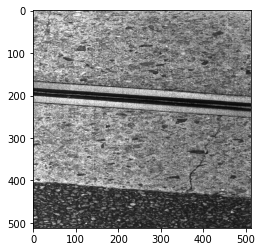

In [5]:
plt.imshow(patch)

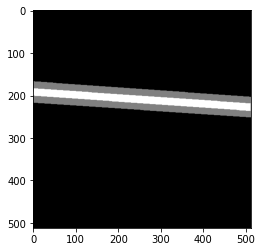

In [6]:
plt.imshow(mask, cmap='gray')

In [7]:
def shape_process(patches, masks):
    masks = tf.where(masks == 100, 1, 0)
    return patches, masks

train_ds = load_segmentation(train_ids, coco, "detection", shuffle=True)
train_ds = train_ds.cache().batch(16).map(shape_process).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = load_segmentation(test_ids, coco, "detection")
test_ds = test_ds.batch(16).map(shape_process)

In [8]:
for patches, masks in train_ds.take(1):
    print(patches.shape)
    print(masks.shape)

(16, 512, 512, 3)
(16, 512, 512)


# 모델 빌드 및 학습

In [9]:
model = tf.keras.models.load_model("models/segmentation.h5")

In [10]:
BCE = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(patches, masks, model, optimizer, train_loss):
    with tf.GradientTape() as tape:
        preds = model(patches, training=True)
        loss = BCE(masks,preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
@tf.function
def test_step(patches, masks, model, test_loss):
    preds = model(patches, training=False)
    loss = BCE(masks,preds)
    test_loss(loss)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

template = "Epoch {} : detection train loss {:5f}, accuracy {:.3f}, val loss {:5f}, val accuracy {:.3f}"
optimizer= tf.keras.optimizers.Adam(learning_rate=1E-3)
EPOCH = 20

log_dir = "logs/segmentation"
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(1, EPOCH+1): 
    train_loss.reset_states()
    test_loss.reset_states()

    for i, (patches, masks) in enumerate(train_ds):
        train_step(patches, masks, model, optimizer, train_loss)
        print("Epoch : {} train_step : {}".format(epoch, i))
        
    for i, (patches, labels) in enumerate(test_ds):
        test_step(patches, masks, model, test_loss)
    print(template.format(epoch,
                      train_loss.result().numpy(),
                     test_loss.result().numpy()))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result().numpy(), step=epoch)

Epoch : 1 train_step : 0
Epoch : 1 train_step : 1
Epoch : 1 train_step : 2
Epoch : 1 train_step : 3
Epoch : 1 train_step : 4
Epoch : 1 train_step : 5
Epoch : 1 train_step : 6
Epoch : 1 train_step : 7
Epoch : 1 train_step : 8
Epoch : 1 train_step : 9
Epoch : 1 train_step : 10
Epoch : 1 train_step : 11
Epoch : 1 train_step : 12
Epoch : 1 train_step : 13
Epoch : 1 train_step : 14
Epoch : 1 train_step : 15
Epoch : 1 train_step : 16
Epoch : 1 train_step : 17
Epoch : 1 train_step : 18
Epoch : 1 train_step : 19
Epoch : 1 train_step : 20
Epoch : 1 train_step : 21
Epoch : 1 train_step : 22
Epoch : 1 train_step : 23
Epoch : 1 train_step : 24
Epoch : 1 train_step : 25
Epoch : 1 train_step : 26
Epoch : 1 train_step : 27
Epoch : 1 train_step : 28
Epoch : 1 train_step : 29
Epoch : 1 train_step : 30
Epoch : 1 train_step : 31
Epoch : 1 train_step : 32
Epoch : 1 train_step : 33
Epoch : 1 train_step : 34
Epoch : 1 train_step : 35
Epoch : 1 train_step : 36
Epoch : 1 train_step : 37
Epoch : 1 train_step :

In [ ]:
model.save("checkpoints/segmentation/model.h5")